In [1]:
import sys
sys.path.append("../implementations")
from classes.frameworks import Frameworks
import copy
import os
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
from collections import defaultdict
import numpy as np
import dill
import os
frameworks = defaultdict(dict)
memo_dir = "./data/memo/"
random_dir = "./data/random_selection/"
old_mutation_dir = "./data/old_mutations/"
all_experiments = {
    "memo": memo_dir,
    "random": random_dir,
    "old_mutation": old_mutation_dir
}

In [2]:
backends = ["tensorflow_new"]
def get_coverage(file_dir):
    arc_coverage = []
    api_coverage = defaultdict(list)
    arc_time = []
    file_list = ["tensorflow_new_api_cov.txt", "tensorflow_new_arcs.txt"]
    with open(os.path.join(file_dir, "tensorflow_new_arcs.txt"), "r") as file:
        content = file.read().split("\n")[:-1]
    for i, line in enumerate(content):
        if "Current time" in line:
            arc_time.append(float(line.split(": ")[-1]))
        if "arcs result" in line:
            arc_coverage.append(float(content[i+1]))
    time = []
    with open(os.path.join(file_dir, "tensorflow_new_api_cov.txt"), "r") as file:
        content = file.read().split("\n")[:-1]
    for i, line in enumerate(content):
        if "Current time" in line:
            time.append(float(line.split(": ")[-1]))
        if "api coverage result" in line:
            api_coverage["api_input"].append(float(content[i+1].split("; ")[3]))
            api_coverage["api_sequence"].append(float(content[i+1].split("; ")[1]))
            api_coverage["api_param"].append(float(content[i+1].split("; ")[2]))
    
    return time, arc_time, arc_coverage, api_coverage["api_input"], api_coverage["api_sequence"], api_coverage["api_param"]


def get_branch(file_path):
    backend = ["tensorflow_new"]
    result_dict = {}
    for bk in backend:
        print("========= working on backend: {} ========".format(bk))
        result_dict[bk] = {}
        result_dict[bk]["time"], result_dict[bk]["arc_time"], result_dict[bk]["arcs"], \
        result_dict[bk]["api_input"], result_dict[bk]["api_sequence"], result_dict[bk]["api_param"] \
        = get_coverage(file_path)
    return result_dict

def get_all_result(experiment_dir):
    result_list = []
    result_list.append(get_branch(experiment_dir))
    return result_list

    
result_memo = get_all_result(all_experiments["memo"])

result_old_mutation = get_all_result(all_experiments["old_mutation"])

result_random = get_all_result(all_experiments["random"])

========= working on backend: tensorflow_new ========
========= working on backend: tensorflow_new ========
========= working on backend: tensorflow_new ========


Working on coverage: api_input
api_input 888 0.6971279373368147
api_input 1167 0.19321148825065274
api_input 1067 0.4360313315926893
Working on coverage: api_param
api_param 888 0.5017081503172279
api_param 1167 0.1059053196681308
api_param 1067 0.34260614934114203
Working on coverage: api_sequence
api_sequence 888 0.1884606816662954
api_sequence 1167 0.041211851191802186
api_sequence 1067 0.07529516596123859


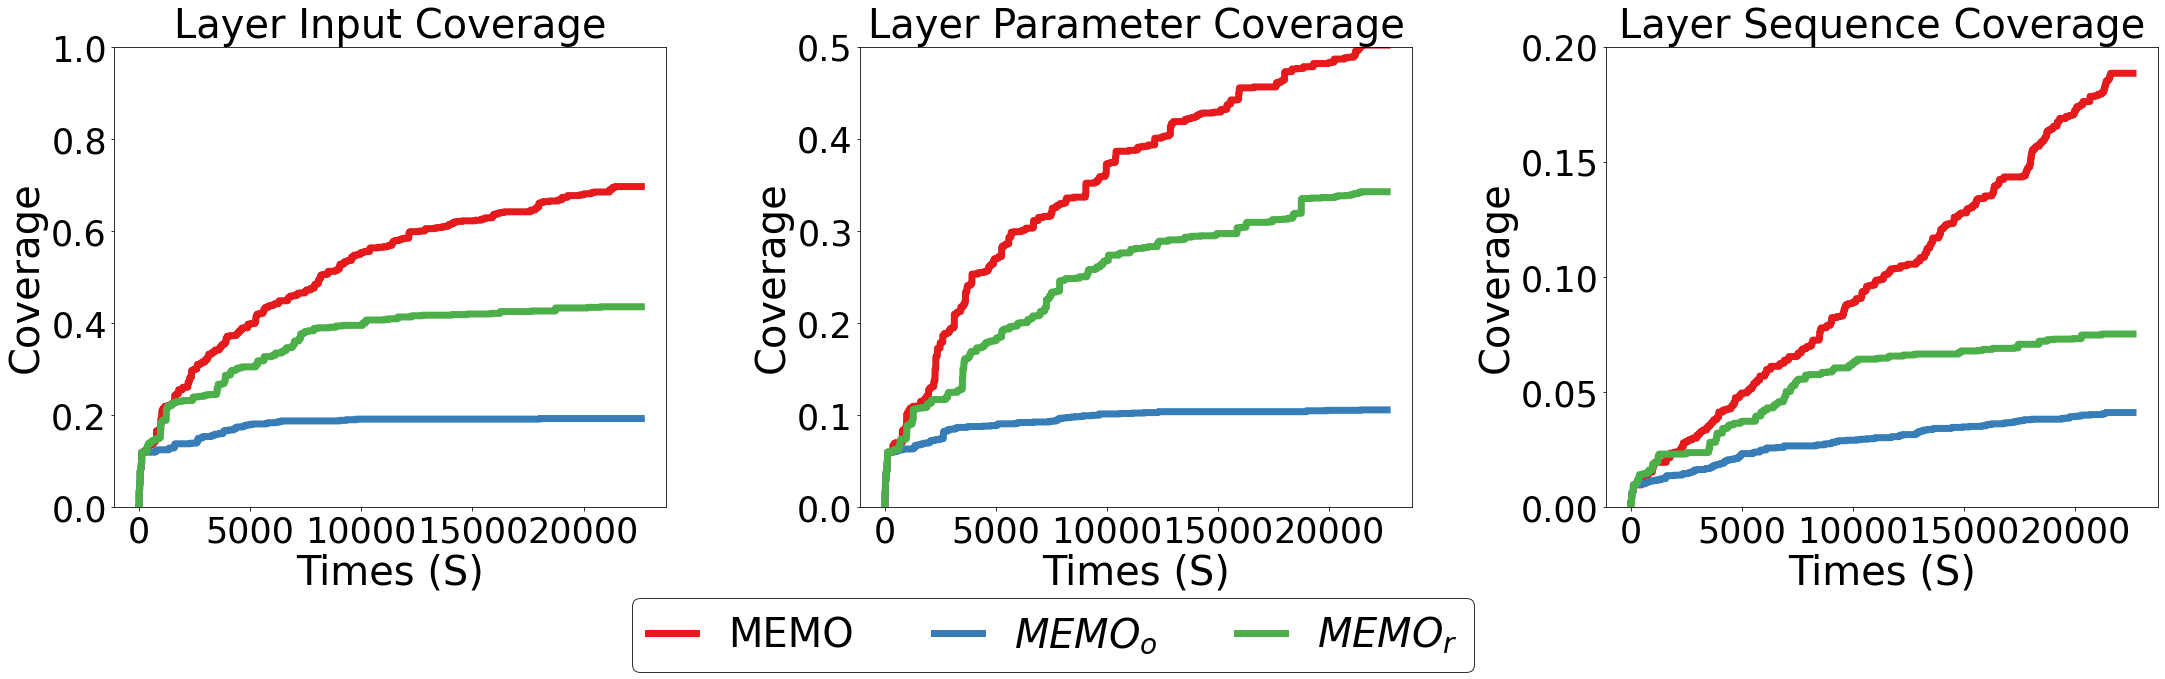

In [4]:
# Draw four graph, each graph represent the test coverage of one framework
import numpy as np
color_list = []
cmap = cm.get_cmap("Set2", 3)
for i in range(cmap.N):
    rgb = cmap(i)[:3]
    color_list.append(matplotlib.colors.rgb2hex(rgb))
memo_color = "#e41a1c"
memo_old_mutation_color = "#377eb8"
memo_random_color = "#4daf4a"

fig = plt.figure(figsize=(50,8))
ATITLE_SIZE = 40
LABEL_SIZE = 40
XTICK_SIZE = 35
YTICK_SIZE = 35
LEGEND_SIZE = 40
FTITLA_SIZE = 30
SCATTER_FONT_SIZE = 14
SCATTER_LINE_SIZE = 2.5
SCATTER_AREA = 100

# plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=ATITLE_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=LABEL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=XTICK_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=YTICK_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LEGEND_SIZE)    # legend fontsize
plt.rc('figure', titlesize=FTITLA_SIZE)  # fontsize of the figure title

left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.35   # the amount of width reserved for blank space between subplots
hspace = 0.2   # the amount of height reserved for white space between subplots

plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)
cov_list = [
#     "arcs", 
    "api_input", 
    "api_param", 
    "api_sequence"
]
# result: [{"tensorflow_new": {"py": {"linehit": []}, "branchhit": }, "c":{}, "time": []}, {"mxnet_new", ...}]
total_time = 360*60+1000  # seconds
def get_time_branch(result_list, cov):
    time_branch = np.zeros(total_time)
    branch = np.array(result_list[cov])
    if cov == "arcs":
        time_list = np.array(result_list["arc_time"])
    else:
        time_list = np.array(result_list["time"])
    print(cov, len(time_list), branch[-1])
    assert len(time_list) == len(branch)
    for i, time in enumerate(time_list):
        time_branch[int(time)] = branch[i]
    for idx in range(1, len(time_branch)):
        if time_branch[idx] == 0:
            time_branch[idx] = time_branch[idx-1]
    return time_branch
    
def get_time_list_property(time_branch_list):
    time_branch_list_array = np.array(time_branch_list)
    min_branch_list = np.min(time_branch_list,axis=0)
    max_branch_list = np.max(time_branch_list,axis=0)
    average_branch_list = np.average(time_branch_list,axis=0)
    return min_branch_list, max_branch_list, average_branch_list

y_lim_list = {
#     "arcs": [7000, 10000], 
    "api_input": [0,1.001], 
    "api_sequence": [0,0.2], 
    "api_param": [0,0.5]
}
for i, cov in enumerate(cov_list):
    print(f"Working on coverage: {cov}")
    memo_time_branch_list = get_time_branch(result_memo[0]["tensorflow_new"], cov)
    
    old_time_branch_list = get_time_branch(result_old_mutation[0]["tensorflow_new"], cov)

    random_time_branch_list = get_time_branch(result_random[0]["tensorflow_new"], cov)
    
    ax=plt.subplot(1,4,i+1)
    ax.set_ylim(y_lim_list[cov])
    plt.plot(memo_time_branch_list, "-", alpha=1, label="MEMO", color=memo_color, linewidth=7)
    plt.plot(old_time_branch_list, "-", alpha=1, label=r"$MEMO_{o}$", color=memo_old_mutation_color, linewidth=7)
    plt.plot(random_time_branch_list, "-", alpha=1, label=r"$MEMO_{r}$", color=memo_random_color, linewidth=7)
    
    plt.xlabel('Times (S)')
    if cov == "arcs":
        plt.ylabel('# Covered Branches')
    else:
        plt.ylabel("Coverage")

    if cov == "api_input": title="Layer Input Coverage"
    if cov == "api_sequence": title="Layer Sequence Coverage"
    if cov == "api_param": title="Layer Parameter Coverage"
    if cov == "arcs": title="Covered Branches"
    if cov == "theano": title="Theano"
    if cov == "pytorch": title="PyTorch"
    plt.title(title)
plt.legend(ncol=3,edgecolor='k', loc='lower center', bbox_to_anchor=(-1, -0.4), handlelength=1.2, labelspacing=1.35)
plt.savefig("RQ4_Ablation.pdf",bbox_inches='tight')
